In [1]:
"""
Created on Tuesday 3 April 2022
Author: ZMW
"""
#import libraries

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import warnings
warnings.filterwarnings("ignore")
from sklearn import metrics
from sklearn.model_selection import cross_val_score, KFold
from sklearn.metrics import roc_curve,roc_auc_score
from sklearn.metrics import accuracy_score,classification_report,confusion_matrix
from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import accuracy_score
import pickle
from xgboost import cv
from numpy import mean
from numpy import std
from xgboost import plot_importance
import xgboost as xgb
from hyperopt import STATUS_OK, Trials, fmin, hp, tpe
import shap
from sklearn.preprocessing import StandardScaler, LabelEncoder
import os


### Reading dataset

In [2]:
# data path
path = os.getcwd()
dirname = os.path.dirname(path)

# for window
#data_file = "data\\data.csv"

#for linux
data_file = 'data/data.csv'
data_path = os.path.join(dirname,data_file)

In [3]:
#Load the fitted dataset
data = pd.read_csv(data_path)

In [4]:
data.head()

,Label,Patient,A1_1Deg,A1_1Deg_err,B1_1Deg,B1_1Deg_err,C1_1Deg,C1_1Deg_err,1_Deg_ResSoS_1,1Deg_AdjR2_1,...,8_Deg_ResSoS_1,8Deg_AdjR2_1,A2_8Deg,A2_8Deg_err,B2_8Deg,B2_8Deg_err,C2_8Deg,C2_8Deg_err,8_Deg_ResSoS_2,8Deg_AdjR2_2
0,Not_Parkinson's,PD001,10.388190,0.006132,0.049329,0.000006,0.011989,0.000337,8928.709194,0.990598,...,6698.838281,0.951413,10.273124,0.044206,0.386347,0.000384,0.037356,0.002439,6809.455800,0.939095
1,Not_Parkinson's,PD002,10.429055,0.006929,0.049478,0.000007,0.002837,0.000379,11388.604704,0.988092,...,4769.901822,0.967360,11.482500,0.049154,0.395412,0.000380,-0.002486,0.002419,8383.481840,0.939586
2,Not_Parkinson's,PD003,10.097088,0.005091,0.049368,0.000006,0.005707,0.000287,6140.292312,0.993141,...,3488.747176,0.968709,10.084338,0.019838,0.394595,0.000174,-0.035466,0.001106,1349.962240,0.987259
3,Not_Parkinson's,PD004,10.482881,0.022179,0.049585,0.000023,0.016056,0.001212,117748.979710,0.879372,...,10972.045844,0.920137,11.493414,0.048867,0.401386,0.000377,-0.042463,0.002395,8242.136178,0.940370
4,Not_Parkinson's,PD005,10.181273,0.008833,0.049368,0.000010,0.001569,0.000494,18447.340517,0.979692,...,18268.960666,0.809586,10.370348,0.036121,0.395392,0.000308,-0.030769,0.001960,4485.300264,0.960035


In [5]:
# Standardization
sc = StandardScaler()
data_input = pd.DataFrame(sc.fit_transform(data.iloc[:,2:]),index=data.iloc[:,2:].index, columns= data.iloc[:,2:].columns)

In [6]:
# Features and labels
x = data_input.iloc[:,2:]
y = data.iloc[:,0]


In [7]:
## Convert the categorical variables to number
LabelEncoder_gender = LabelEncoder()
y = LabelEncoder_gender.fit_transform(y)

In [8]:
# spliting feature
x_train, x_test,y_train,y_test = train_test_split(x,y,test_size=0.2,random_state=0)

### Baseline model

In [9]:
params = {
            'objective':'binary:logistic',
            'max_depth': 4,
            'alpha':3,
            'learning_rate':1.0,
            'n_estimators':100}
model = xgb.XGBClassifier(**params)

all_run = []
for split in range(30):
    #cv = ShuffleSplit(n_splits=5, test_size=0.3, random_state=split)
    kfold = KFold(n_splits=5, shuffle=True,random_state=split)
    scores = cross_val_score(model,x,y,scoring='roc_auc', cv=kfold)
    result = [[split,scores.mean()]]
    all_run += result
#print(all_run)
all_run_df = pd.DataFrame(all_run,columns=['split','acc'])
print("XGBoost based model accuracy score: {0:0.4f}".format(all_run_df['acc'].mean()))

XGBoost based model accuracy score: 0.5935


### Hyperparameter Tuning

In [539]:
params = {'learning_rate': hp.uniform('learning_rate', 0.01, 0.2),
          'gamma': hp.uniform('gamma', 0, 9),
          'min_child_weight': hp.choice('min_child_weight', range(1, 6)),
          'subsample': hp.uniform('subsample', 0.7, 1.0),
          'colsample_bytree': hp.uniform('colsample_bytree', 0.5, 1.0),
          'max_depth': hp.choice('max_depth', range(3, 18)),
          'n_estimators': hp.choice('n_estimators', [50, 100, 200, 300, 400, 500, 1000])}
    
min_child_weight_ls = range(1, 6)
max_depth_ls = range(3, 18)
n_estimators_ls = [100, 200, 300, 400, 500, 1000, 1500, 2000]

In [431]:
def hyperparameter_tuning(params):
    clf=xgb.XGBClassifier(**params, n_jobs=6, random_state=1, seed=1,
                              use_label_encoder=False)
    clf.fit(x_train, y_train,eval_metric='auc')
    pred = clf.predict(x_test)
    accuracy = accuracy_score(y_test, pred)
#     print ("SCORE:", accuracy) 
    return {'loss': -accuracy, 'status': STATUS_OK }

In [432]:
trials = Trials()

best_hyperparams = fmin(fn = hyperparameter_tuning,
                        space = params,
                        algo = tpe.suggest,
                        max_evals = 50,
                        trials = trials)

100%|██████████| 50/50 [00:05<00:00,  9.73trial/s, best loss: -0.8333333333333334]


In [433]:
best_model = xgb.XGBClassifier(n_estimators=n_estimators_ls[best_hyperparams['n_estimators']],
                               max_depth=max_depth_ls[best_hyperparams['max_depth']],
                               min_child_weight=min_child_weight_ls[best_hyperparams['min_child_weight']],
                               learning_rate=best_hyperparams['learning_rate'],
                               gamma=best_hyperparams['gamma'],
                               subsample=best_hyperparams['subsample'],
                               colsample_bytree=best_hyperparams['colsample_bytree'],
                               n_jobs=6, random_state=1, seed=1)
    

In [10]:

#save
file_name = 'hyper_xgb.pkl'
#pickle.dump(best_model, open(file_name,'wb'))

#load
xgb_hyper = pickle.load(open(file_name,'rb'))



### AUC score with tuned parameters

In [11]:
all_run = []
for split in range(30):
    #cv = ShuffleSplit(n_splits=5, test_size=0.3, random_state=split)
    kfold = KFold(n_splits=5, shuffle=True,random_state=split)
    scores = cross_val_score(xgb_hyper,x,y,scoring='roc_auc', cv=kfold)
    result = [[split,scores.mean()]]
    all_run += result
#print(all_run)
all_run_df = pd.DataFrame(all_run,columns=['split','acc'])
print(all_run_df['acc'].mean(),all_run_df['acc'].std())

0.7068910256410257 0.09485193201826382


### Feature importance

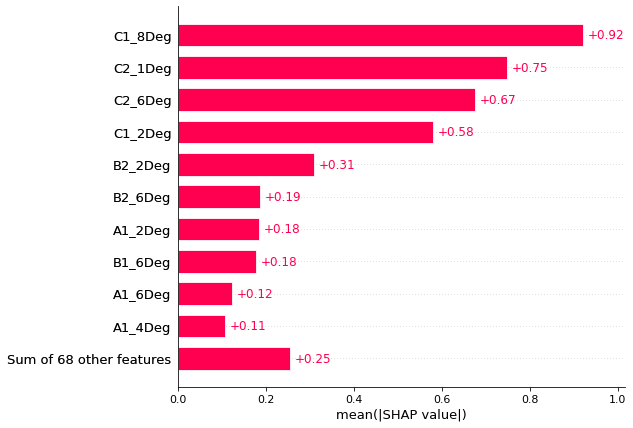

In [14]:
classifier = xgb.XGBClassifier()
classifier.fit(x_train,y_train)
explainer = shap.Explainer(classifier)
shap_values = explainer(x_test)
shap.plots.bar(shap_values, max_display=11,show=False)

In [15]:
data = data[['Label','Patient','C1_8Deg','C2_1Deg','C2_6Deg','C1_2Deg',
            'B2_2Deg','B2_6Deg','A1_2Deg','B1_6Deg','A1_6Deg','A1_4Deg']]
x = data.iloc[:,2:]
# sc = StandardScaler()
# x = sc.fit_transform(x)
y = data.iloc[:,0]
y = LabelEncoder_gender.fit_transform(y)
# x_train, x_test,y_train,y_test = train_test_split(x,y,test_size=0.3,random_state=0)
# best_model.fit(x_train, y_train)
#best_model.fit(x,y,eval_metric='auc')
all_run = []
for split in range(30):
    #cv = ShuffleSplit(n_splits=5, test_size=0.3, random_state=split)
    kfold = KFold(n_splits=5, shuffle=True,random_state=split)
    scores = cross_val_score(xgb_hyper,x,y,scoring='roc_auc', cv=kfold)
    result = [[split,scores.mean()]]
    all_run += result
#print(all_run)
all_run_df = pd.DataFrame(all_run,columns=['split','acc'])
print(all_run_df['acc'].mean(),all_run_df['acc'].std())
    

0.8152350427350428 0.08195288816413086


### Confusion matrix

In [24]:
xgb_hyper.fit(x_train, y_train)
y_pred = xgb_hyper.predict(x_test)
predictions = [round(value) for value in y_pred]

# Accuracy
accuracy = roc_auc_score(y_test,predictions)
print("Accuracy: %.2f%%" % (accuracy * 100.0))

Accuracy: 83.33%


In [25]:
#confusion matrix
confusion = confusion_matrix(y_test,predictions)
print(confusion)

#  Sensitivity 
TP = confusion[1,1] # true positives
TN = confusion[0,0] # true negatives
FP = confusion[0,1] # False positives
FN = confusion[1,0] # false negatives

sensitivity = TP/float(TP+FN)
print(sensitivity)

# Specificity
specificity = TN/float(TN+FP)
print(specificity)


auc_score = roc_auc_score(y_test,predictions)
fpr , tpr , thresholds = roc_curve (y_test, predictions)
print(auc_score)

[[3 0]
 [1 2]]
0.6666666666666666
1.0
0.8333333333333333


In [44]:
x_test.iloc[0:1,:]

,B1_1Deg,B1_1Deg_err,C1_1Deg,C1_1Deg_err,1_Deg_ResSoS_1,1Deg_AdjR2_1,A2_1Deg,A2_1Deg_err,B2_1Deg,B2_1Deg_err,...,8_Deg_ResSoS_1,8Deg_AdjR2_1,A2_8Deg,A2_8Deg_err,B2_8Deg,B2_8Deg_err,C2_8Deg,C2_8Deg_err,8_Deg_ResSoS_2,8Deg_AdjR2_2
2,0.063202,-0.81095,-0.212194,-0.810821,-0.522584,0.59585,-0.239333,-1.246402,-0.264076,-1.330139,...,-0.643358,0.637375,-0.225273,-1.142608,-0.778159,-1.082598,0.142534,-1.083575,-0.843762,0.76944


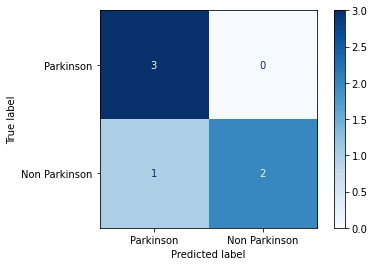

In [26]:
class_names = ['Parkinson','Non Parkinson']
disp = plot_confusion_matrix(xgb_hyper, x_test, y_test,
                                 display_labels=class_names,
                                 cmap=plt.cm.Blues)

#plt.savefig('cm.png',dpi=300)
plt.show()

In [240]:
# def run_best_model(arg):
#     # data set preparation
#     # data = pd.read_csv('data.csv')
#     data = arg

#     ## Convert the categorical variables to number
#     LabelEncoder_gender = LabelEncoder()
#     data['Label'] = LabelEncoder_gender.fit_transform(data['Label'])
    
#     # run 30 repetitions
#     splits = 30
#     all_set = []
#     for split in range(1,splits+1):
        
#         seed = split

#         # data set preparation
#         train , test = train_test_split(data,train_size = 0.7,shuffle=True,random_state=seed)
#         #validate , test = train_test_split(rest, train_size = 0.5, shuffle=True)

#         # training set
#         data_tra_x = train.iloc[:,2:].values
#         data_tra_y = train.iloc[:,0].values


#         # validation set
#         # data_val_x = validate.iloc[:,2:].values
#         # data_val_y = validate.iloc[:,0].values


#         # test set
#         data_tes_x = test.iloc[:,2:].values
#         data_tes_y =  test.iloc[:,0].values

#         best_model = xgb.XGBClassifier(n_estimators=n_estimators_ls[best_hyperparams['n_estimators']],
#                                max_depth=max_depth_ls[best_hyperparams['max_depth']],
#                                min_child_weight=min_child_weight_ls[best_hyperparams['min_child_weight']],
#                                learning_rate=best_hyperparams['learning_rate'],
#                                gamma=best_hyperparams['gamma'],
#                                subsample=best_hyperparams['subsample'],
#                                colsample_bytree=best_hyperparams['colsample_bytree'],
#                                n_jobs=6, random_state=1, seed=1,use_label_encoder=False)
    
#         best_model.fit(data_tra_x,data_tra_y,eval_metric='auc')

#         # training error
#         tra_pred = best_model.predict_proba(data_tra_x)
#         tra_results = [split,'tra',roc_auc_score(data_tra_y,tra_pred[:,1])]
      

#         # validation error
#         # val_pred = best_model.predict_proba(data_val_x)
#         # val_results = [split,'val',roc_auc_score(data_val_y,val_pred[:,1])]
        

#         # testing error
#         tes_pred = best_model.predict_proba(data_tes_x)
#         tes_results = [' ','tes',roc_auc_score(data_tes_y,tes_pred[:,1])]
    

#         all_set += tra_results,tes_results

#     all_set_df = pd.DataFrame(all_set,columns=['split','set','acc'])

#     print('train accuracy',all_set_df[all_set_df['set'] == 'tra']['acc'].mean(),'std',all_set_df[all_set_df['set'] == 'tra']['acc'].std())
#     #print('validation accuracy',all_set_df[all_set_df['set'] == 'val']['acc'].mean(),'std',all_set_df[all_set_df['set'] == 'tra']['acc'].std())
#     print('test accuracy',all_set_df[all_set_df['set'] == 'tes']['acc'].mean(),'std',all_set_df[all_set_df['set'] == 'tes']['acc'].std())

# #run_best_model(data)

In [241]:
run_best_model(data)

train accuracy 0.9679476726976727 std 0.026817628244023988
test accuracy 0.7388624338624339 std 0.21217626022516917


In [517]:
from sklearn.model_selection import ShuffleSplit

In [311]:
from sklearn.model_selection import cross_val_score, KFold
best_model = xgb.XGBClassifier(n_estimators=n_estimators_ls[best_hyperparams['n_estimators']],
                               max_depth=max_depth_ls[best_hyperparams['max_depth']],
                               min_child_weight=min_child_weight_ls[best_hyperparams['min_child_weight']],
                               learning_rate=best_hyperparams['learning_rate'],
                               gamma=best_hyperparams['gamma'],
                               subsample=best_hyperparams['subsample'],
                               colsample_bytree=best_hyperparams['colsample_bytree'],
                               n_jobs=6, random_state=1, seed=1,use_label_encoder=False)
data = data[['Label','Patient','C1_8Deg','C2_1Deg','C2_6Deg','C1_2Deg',
            'B2_2Deg','B2_6Deg','A1_2Deg','B1_6Deg','A1_6Deg','A2_4Deg']]
x = data.iloc[:,2:]
# sc = StandardScaler()
# x = sc.fit_transform(x)
y = data.iloc[:,0]
y = LabelEncoder_gender.fit_transform(y)
# x_train, x_test,y_train,y_test = train_test_split(x,y,test_size=0.3,random_state=0)
# best_model.fit(x_train, y_train)
#best_model.fit(x,y,eval_metric='auc')
all_run = []
for split in range(30):
    #cv = ShuffleSplit(n_splits=5, test_size=0.3, random_state=split)
    kfold = KFold(n_splits=5, shuffle=True,random_state=split)
    scores = cross_val_score(best_model,x,y,scoring='roc_auc', cv=kfold)
    result = [[split,scores.mean()]]
    all_run += result
#print(all_run)
all_run_df = pd.DataFrame(all_run,columns=['split','acc'])
print(all_run_df['acc'].mean(),all_run_df['acc'].std())
    

0.7777884615384616 0.0870341738178501


In [15]:
kfold = KFold(n_splits=5, shuffle=True)
scores = cross_val_score(best_model,x,y,scoring='recall', cv=kfold)
scores.mean()

[10:41:38] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117899018/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[10:41:38] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117899018/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[10:41:38] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117899018/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[10:41:38] WARNING: /Users/runner/miniforge3/cond

0.7166666666666666

### Feature importance

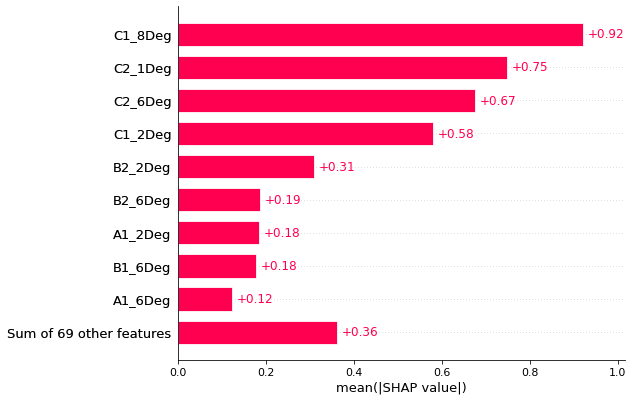

In [500]:
classifier = xgb.XGBClassifier()
classifier.fit(x_train,y_train)
explainer = shap.Explainer(classifier)
shap_values = explainer(x_test)
shap.plots.bar(shap_values, max_display=10,show=False)

In [481]:
import matplotlib
shap_values = shap.TreeExplainer(classifier).shap_values(x)
f = plt.figure()
shap.summary_plot(shap_values, x,max_display=10,show=False)
fig = matplotlib.pyplot.gcf()

ValueError: This reshape error is often caused by passing a bad data matrix to SHAP. See https://github.com/slundberg/shap/issues/580

In [443]:
classifier.get_booster().get_score(importance_type='gain')

{'f10': 0.6989894509315491,
 'f14': 1.207188606262207,
 'f16': 0.13222992420196533,
 'f18': 1.1786932945251465,
 'f22': 3.0714287757873535,
 'f24': 0.5126723647117615,
 'f30': 1.9052653312683105,
 'f42': 0.8900811672210693,
 'f46': 0.7167508006095886,
 'f48': 0.960930347442627,
 'f56': 2.033273458480835,
 'f58': 2.474313974380493,
 'f66': 1.3389066457748413,
 'f70': 0.07729071378707886,
 'f74': 0.07751685380935669}

<AxesSubplot:title={'center':'Feature importance'}, xlabel='F score', ylabel='Features'>

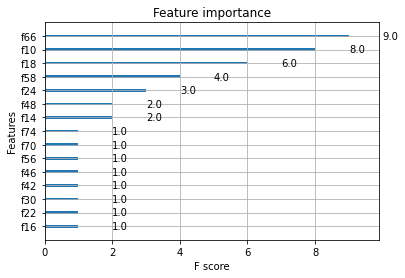

In [445]:
xgb.plot_importance(classifier)

xgb.plot_importance(classifier)

In [ ]:
[['Label','Patient','C1_8Deg','C2_1Deg','C2_6Deg','C1_2Deg',
            'B2_2Deg','B2_6Deg','A1_2Deg','B1_6Deg','A1_6Deg','A2_4Deg']]

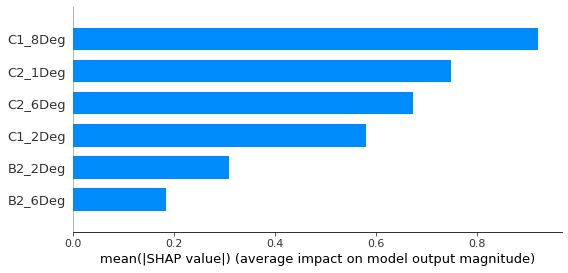

In [529]:
explainer = shap.TreeExplainer(classifier)
shap_values = explainer.shap_values(x_test)
shap.summary_plot(shap_values, x_test, plot_type='bar')

In [442]:
classifier.feature_importances_

array([0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.04046124, 0.        , 0.        , 0.        , 0.06987852,
       0.        , 0.00765417, 0.        , 0.06822906, 0.        ,
       0.        , 0.        , 0.17779069, 0.        , 0.02967621,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.11028693, 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.05152265, 0.        , 0.        ,
       0.        , 0.04148936, 0.        , 0.05562378, 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.11769672, 0.        , 0.1432265 , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.07750306, 0.        , 0.        , 0.        ,
       0.004474  , 0.        , 0.        , 0.        , 0.00448

In [458]:
len(X_training)

29

In [462]:
len(classifier.feature_importances_[0:29])

29

### Model with custom features

In [245]:
data = data[['Label','Patient','C2_6Deg','B2_4Deg','B2_6Deg','C2_4Deg',
            'C1_2Deg','C1_8Deg','A1_4Deg_err','C2_1Deg','B1_8Deg','B2_8Deg']]
def run_best_model(arg):
    # data set preparation
    # data = pd.read_csv('data.csv')
    data = arg

    ## Convert the categorical variables to number
    LabelEncoder_gender = LabelEncoder()
    data['Label'] = LabelEncoder_gender.fit_transform(data['Label'])
    
    # run 30 repetitions
    splits = 50
    all_set = []
    for split in range(1,splits+1):
        
        seed = split

        # data set preparation
        train , test = train_test_split(data,train_size = 0.7,shuffle=True,random_state=seed)
        #validate , test = train_test_split(rest, train_size = 0.5, shuffle=True)

        # training set
        data_tra_x = train.iloc[:,2:].values
        data_tra_y = train.iloc[:,0].values


        # validation set
        # data_val_x = validate.iloc[:,2:].values
        # data_val_y = validate.iloc[:,0].values


        # test set
        data_tes_x = test.iloc[:,2:].values
        data_tes_y =  test.iloc[:,0].values

        best_model = xgb.XGBClassifier(n_estimators=n_estimators_ls[best_hyperparams['n_estimators']],
                               max_depth=max_depth_ls[best_hyperparams['max_depth']],
                               min_child_weight=min_child_weight_ls[best_hyperparams['min_child_weight']],
                               learning_rate=best_hyperparams['learning_rate'],
                               gamma=best_hyperparams['gamma'],
                               subsample=best_hyperparams['subsample'],
                               colsample_bytree=best_hyperparams['colsample_bytree'],
                               n_jobs=6, random_state=1, seed=1,use_label_encoder=False)
    
        best_model.fit(data_tra_x,data_tra_y,eval_metric='auc')

        # training error
        tra_pred = best_model.predict_proba(data_tra_x)
        tra_results = [split,'tra',roc_auc_score(data_tra_y,tra_pred[:,1])]
      

        # validation error
        # val_pred = best_model.predict_proba(data_val_x)
        # val_results = [split,'val',roc_auc_score(data_val_y,val_pred[:,1])]
        

        # testing error
        tes_pred = best_model.predict_proba(data_tes_x)
        tes_results = [' ','tes',roc_auc_score(data_tes_y,tes_pred[:,1])]
    

        all_set += tra_results,tes_results

    all_set_df = pd.DataFrame(all_set,columns=['split','set','acc'])

    print('train accuracy',all_set_df[all_set_df['set'] == 'tra']['acc'].mean()),#'std',all_set_df[all_set_df['set'] == 'tra']['acc'].std())
    #print('validation accuracy',all_set_df[all_set_df['set'] == 'val']['acc'].mean(),'std',all_set_df[all_set_df['set'] == 'tra']['acc'].std())
    print('test accuracy',all_set_df[all_set_df['set'] == 'tes']['acc'].mean()),#'std',all_set_df[all_set_df['set'] == 'tes']['acc'].std())

#run_best_model(data)

In [246]:
run_best_model(data)

train accuracy 0.9958471805971806
test accuracy 0.7389841269841269


In [248]:
best_model.fit(x_train, y_train)
y_pred = best_model.predict(x_test)
predictions = [round(value) for value in y_pred]

# Accuracy
accuracy = accuracy_score(y_test,predictions)
print("Accuracy: %.2f%%" % (accuracy * 100.0))

Accuracy: 100.00%


In [683]:
print(classification_report(y_pred,y_test))

              precision    recall  f1-score   support

           0       1.00      0.80      0.89         5
           1       0.80      1.00      0.89         4

    accuracy                           0.89         9
   macro avg       0.90      0.90      0.89         9
weighted avg       0.91      0.89      0.89         9



### Confusion Matrix

In [684]:
#confusion matrix
confusion = confusion_matrix(y_test,predictions)
print(confusion)

#  Sensitivity 
TP = confusion[1,1] # true positives
TN = confusion[0,0] # true negatives
FP = confusion[0,1] # False positives
FN = confusion[1,0] # false negatives

sensitivity = TP/float(TP+FN)
print(sensitivity)

# Specificity
specificity = TN/float(TN+FP)
print(specificity)


auc_score = roc_auc_score(y_test,predictions)
fpr , tpr , thresholds = roc_curve (y_test, predictions)
print(auc_score)

[[4 0]
 [1 4]]
0.8
1.0
0.9


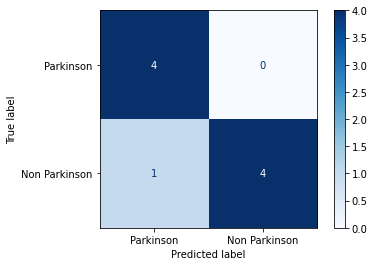

In [687]:
class_names = ['Parkinson','Non Parkinson']
disp = plot_confusion_matrix(best_model, x_test, y_test,
                                 display_labels=class_names,
                                 cmap=plt.cm.Blues)

plt.savefig('cm.png',dpi=300)
plt.show()


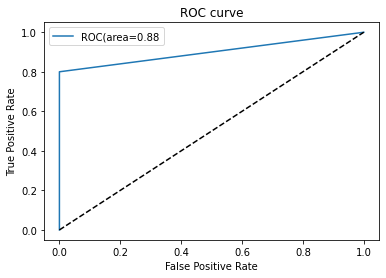

In [95]:
def plot_roc_curve(fpr,tpr): 
  random_probs = [0 for i in range(len(y_test))]
  p_fpr, p_tpr, _ = roc_curve(y_test, random_probs, pos_label=1)
  plt.plot(fpr,tpr,label='ROC(area=0.88')
  plt.plot(p_fpr, p_tpr,'--',color='black') 
  plt.axis([-0.05,1.05,-0.05,1.05]) 
  plt.title('ROC curve')
  plt.xlabel('False Positive Rate') 
  plt.ylabel('True Positive Rate') 
  plt.legend()
  plt.savefig('roc_curve.png',dpi=300)
  plt.show()    
  
plot_roc_curve (fpr,tpr)
#plt.savefig('roc.png',dpi=300)

In [14]:
from sklearn.model_selection import learning_curve
from sklearn.preprocessing import StandardScaler

In [62]:
x = data.iloc[:,2:].values
sc_x = StandardScaler()
x = sc_x.fit_transform(x)
y = data.iloc[:,0].values

In [17]:
#model = xgb.XGBClassifier()
train_sizes = np.linspace(0.1, 1.0, 10)
train_sizes, train_scores, valid_scores = learning_curve(
    best_model, x, y, train_sizes=train_sizes, cv=5,scoring='accuracy')
train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)

test_mean = np.mean(valid_scores, axis=1)
test_std = np.std(valid_scores, axis=1)

[12:26:57] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117899018/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[12:26:57] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117899018/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[12:26:58] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117899018/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[12:26:58] WARNING: /Users/runner/miniforge3/cond

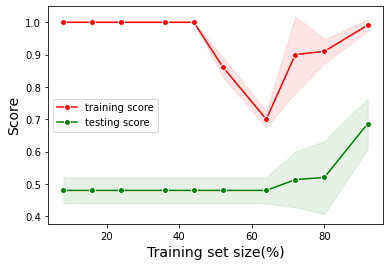

In [18]:
train_scores_mean = train_scores.mean(axis=1)
train_scores_std = train_scores.std(axis=1)

valid_scores_mean = valid_scores.mean(axis = 1)
valid_scores_std = valid_scores.std(axis=1)
fig, ax = plt.subplots()
ax.plot(train_sizes, train_scores_mean,"o-",markeredgecolor='white', label = 'training score',color='r')
ax.fill_between(train_sizes,
        train_scores_mean - train_scores_std,
        train_scores_mean + train_scores_std,
        alpha=0.1,
        color="r",
    )
ax.plot(train_sizes, valid_scores_mean, "o-",markeredgecolor='w', label = 'testing score',color='g')
ax.fill_between(train_sizes,
        valid_scores_mean - valid_scores_std,
        valid_scores_mean + valid_scores_std,
        alpha=0.1,
        color="g",
    )
#ax.set_xticks([0,331,662,993,1324,1656])
ax.set_xticklabels([0,20,40,60,80,100,])
ax.set_ylabel('Score', fontsize = 14)
ax.set_xlabel('Training set size(%)', fontsize = 14)
#ax.set_title('Learning curve for a RF model', fontsize = 14, y = 1.03)
ax.legend()
#
plt.show()

In [24]:
# x = data.iloc[:,2:]
# sc_x = StandardScaler()
# x = sc_x.fit_transform(x)
# y = data.iloc[:,0]
X_train, X_test, Y_train, Y_test = train_test_split(x,y, test_size = 0.2)
model = xgb.XGBClassifier()
model.fit(X_train, Y_train)

[10:43:39] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117899018/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
              gamma=0, gpu_id=-1, importance_type=None,
              interaction_constraints='', learning_rate=0.300000012,
              max_delta_step=0, max_depth=6, min_child_weight=1, missing=nan,
              monotone_constraints='()', n_estimators=100, n_jobs=8,
              num_parallel_tree=1, predictor='auto', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None)

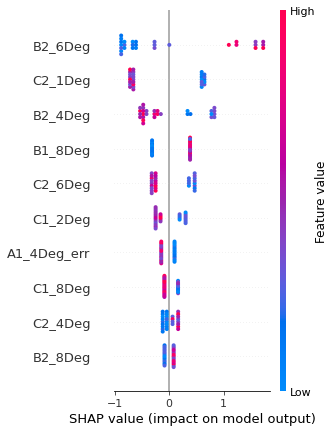

In [31]:
# x = data.iloc[:,2:]
# # sc_x = StandardScaler()
# # x = sc_x.fit_transform(x)
# y = data.iloc[:,0]
# X_train, X_test, Y_train, Y_test = train_test_split(x,y, test_size = 0.2)
# model = xgb.XGBClassifier()
# model.fit(X_train, Y_train)
import matplotlib
shap_values = shap.TreeExplainer(classifier).shap_values(x)
f = plt.figure()
shap.summary_plot(shap_values, x,max_display=10,show=False)
fig = matplotlib.pyplot.gcf()
fig.set_size_inches(3.5, 7)
#plt.savefig("summary_plot_with_.png", bbox_inches='tight', dpi=600)
plt.show()

In [194]:
explainer = shap.TreeExplainer(classifier)
shap_values = explainer.shap_values(x)
shap.force_plot(explainer.expected_value, shap_values[0, :], x.iloc[0, :])

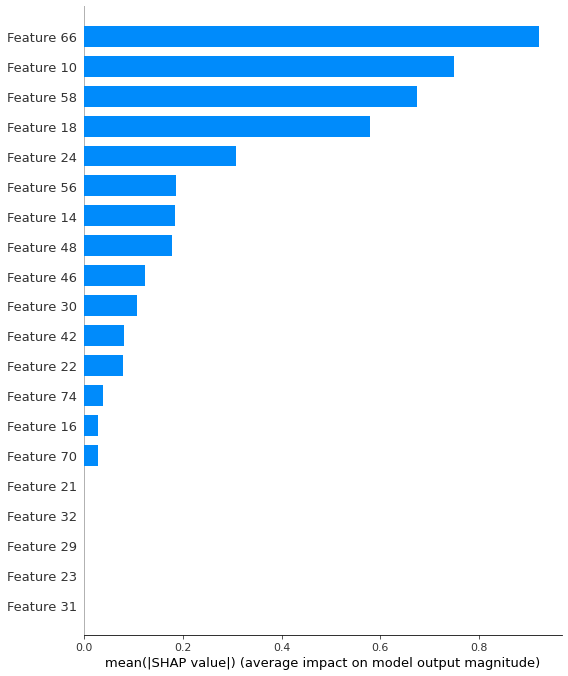

In [468]:
X_importance = x_test
# model = xgb.XGBClassifier(eval_metric='mlogloss',use_label_encoder=False)
# model.fit(x_train, y_train)
# Explain model predictions using shap library:
explainer = shap.TreeExplainer(classifier)
shap_values = explainer.shap_values(X_importance)

feature_names=['B2_6deg','C2_1Deg','B2_4Deg','B1_8Deg','C2_6Deg','C1_2_Deg','A1_4Deg_err',
                                                'C1_8Deg','C2_4Deg','B2_8Deg','A1_4Deg'] 
# # Plot summary_plot as barplot:
# feature_indices = [X_importance[:,:].index.tolist().index(x) for x in feature_names]
# shap.summary_plot(shap_values[1][:,feature_indices], X_importance[:, feature_indices])
shap.summary_plot(shap_values[0:10], X_importance[0:10], plot_type='bar')

In [469]:
vals= np.abs(shap_values).mean(0)
feature_importance = pd.DataFrame(list(zip(x_train.columns,vals)),columns=['col_name','feature_importance'])
feature_importance.sort_values(by=['feature_importance'],ascending=False,inplace=True)
feature_importance[0:5]
importances = feature_importance.sort_values('feature_importance',ascending=False).set_index('col_name')
importances = importances[0:5]
importances.plot.barh(figsize=(10,5))
plt.xlabel('Mean(|SHAP value|) (average impact on model output magnitude) ')
plt.ylabel('Features')

AttributeError: 'numpy.ndarray' object has no attribute 'columns'

In [277]:
feature_importance[0:10]

,col_name,feature_importance
58,B2_6Deg,0.972769
12,C2_1Deg,0.679353
42,B2_4Deg,0.469844
66,B1_8Deg,0.375782
60,C2_6Deg,0.339261
20,C1_2Deg,0.229066
33,A1_4Deg_err,0.135572
68,C1_8Deg,0.121457
44,C2_4Deg,0.105079
74,B2_8Deg,0.083461


In [286]:
shap.plots.beeswarm(shap_values)

UnboundLocalError: local variable 'values' referenced before assignment

IndexError: index 25 is out of bounds for axis 0 with size 20

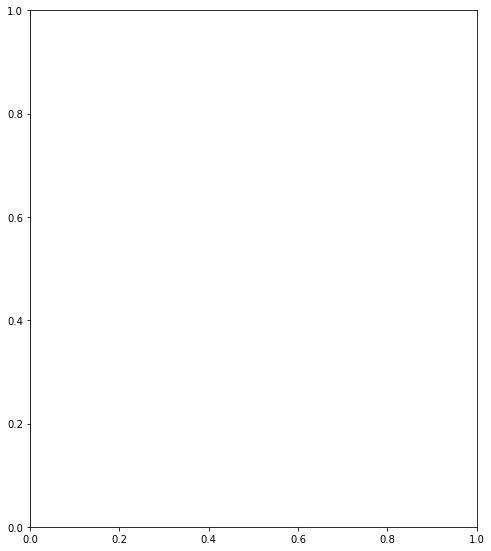

In [309]:
shap.summary_plot(shap_values, x_train)

In [280]:
train_X.iloc[0,:]

AttributeError: 'numpy.ndarray' object has no attribute 'iloc'

In [46]:
shap.initjs()
shap.force_plot(explainer.expected_value, shap_values[0,:], train_X.iloc[0,:])
#plt.savefig("shap.png", format='png', dpi=600)

AttributeError: 'numpy.ndarray' object has no attribute 'iloc'

In [281]:
# visualize the training set predictions
shap.force_plot(explainer.expected_value, shap_values, X_train)

In [282]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.datasets import load_breast_cancer
from shap import TreeExplainer, Explanation
from shap.plots import waterfall

import shap
print(shap.__version__)

#X, y = load_breast_cancer(return_X_y=True, as_frame=True)
#model = RandomForestClassifier(max_depth=5, n_estimators=100).fit(X, y)
explainer = TreeExplainer(model)
sv = explainer(x)
exp = Explanation(sv.values[:,:,1], 
                  sv.base_values[:,1], 
                  data=x.values, 
                  feature_names=x.columns)
idx = 0
waterfall(exp[idx])

0.40.0


IndexError: too many indices for array: array is 2-dimensional, but 3 were indexed

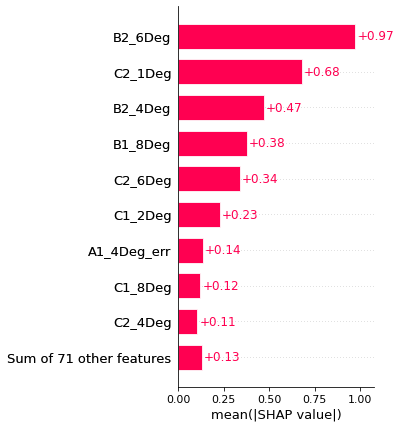

In [231]:
# y = LabelEncoder_gender.fit_transform(y)
# X_train, X_test, Y_train, Y_test = train_test_split(x, y, 
#         test_size = 0.2, random_state = 1234)
# xgb_model = xgb.XGBRegressor(random_state=42)
# xgb_model.fit(X_train, Y_train)

#
# The SHAP Values
import shap
explainer = shap.Explainer(classifier)
shap_values = explainer(x_test)
shap.plots.bar(shap_values, max_display=10,show=False)
fig = matplotlib.pyplot.gcf()
fig.set_size_inches(3.5, 7)
plt.savefig("shap_average_1.png", format='png', dpi=600,bbox_inches='tight')
plt.show()

In [343]:
class_names = ["Not_Parkinson's","Parkinson's"]
# compute SHAP values
explainer = shap.TreeExplainer(classifier)
shap_values = explainer.shap_values(x)
shap.summary_plot(shap_values[0:1],x.values, plot_type="bar",max_display=10,class_names=class_names,feature_names=x.columns)
#plt.savefig("shap_mean.png", format='png', dpi=600,bbox_inches='tight')

AttributeError: 'numpy.ndarray' object has no attribute 'values'

In [267]:
shap.initjs()
shap.force_plot(explainer.expected_value, shap_values[0:], x.iloc[0:], feature_names = x.columns)

# shap.initjs()
# shap.force_plot(explainer.expected_value, shap_values[0,:], x_train.iloc[0,:])

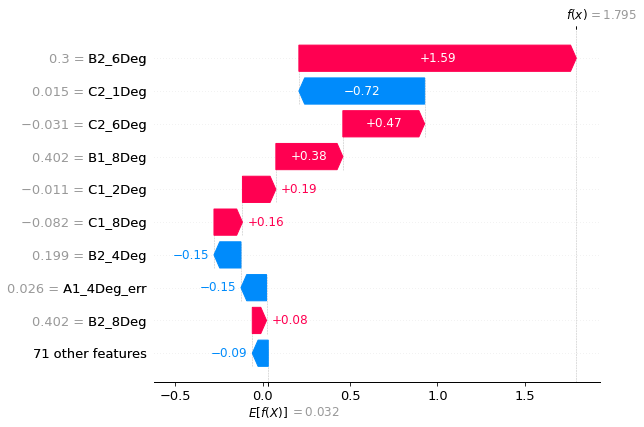

<Figure size 432x288 with 0 Axes>

In [198]:
shap.plots.waterfall(shap_values[1])
plt.savefig("water_fall[1].png", format='png', dpi=600)

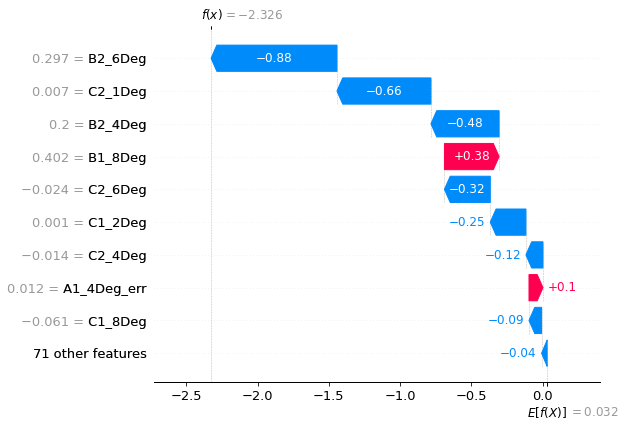

<Figure size 432x288 with 0 Axes>

In [189]:
shap.plots.waterfall(shap_values[0])
plt.savefig("water_fall[0].png", format='png', dpi=600)

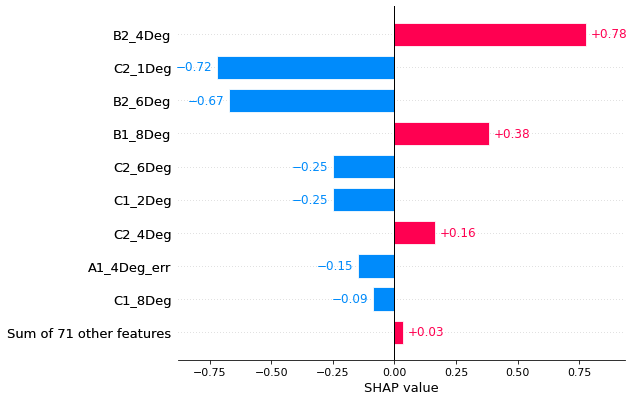

In [230]:
shap.plots.bar(shap_values[8])

In [220]:
shap.plots.bar(shap_values[18])
plt.savefig("shap_bar[1].png", format='png', dpi=600,bbox_inches='tight')
plt.show()

IndexError: index 18 is out of bounds for axis 0 with size 9

In [163]:
explainer = shap.Explainer(classifier)
shap_values = explainer(x_test)
shap.plots.waterfall(shap_values[1],matplotlib = True, show = False)
plt.savefig("water_fall_[1].png", format='png', dpi=600,bbox_inches='tight')

NameError: name 'plt' is not defined

In [209]:
import matplotlib.pyplot as plt
explainer = shap.Explainer(classifier)
shap_values = explainer(x_test)
p = shap.plots.waterfall(shap_values[0],show=False)
fig = matplotlib.pyplot.gcf()
fig.set_size_inches(3.5, 7)
plt.savefig("water_fall_[0].png", format='png', dpi=600,bbox_inches='tight')
plt.show()

NameError: name 'plt' is not defined

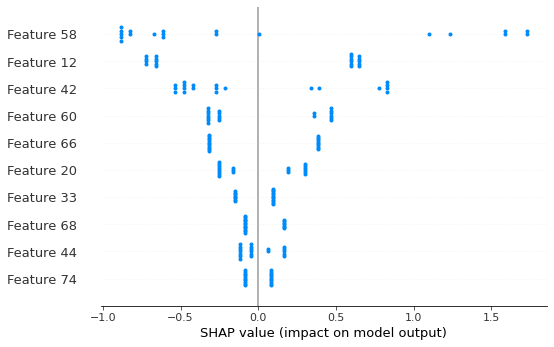

In [382]:
shap.summary_plot(shap_values, max_display=10)
#plt.savefig("shap_value.png", format='png', dpi=600,bbox_inches='tight')


In [310]:
shap.plots.heatmap(shap_values)
#plt.savefig("heat_map.png", format='png', dpi=600)

AttributeError: 'numpy.ndarray' object has no attribute 'values'

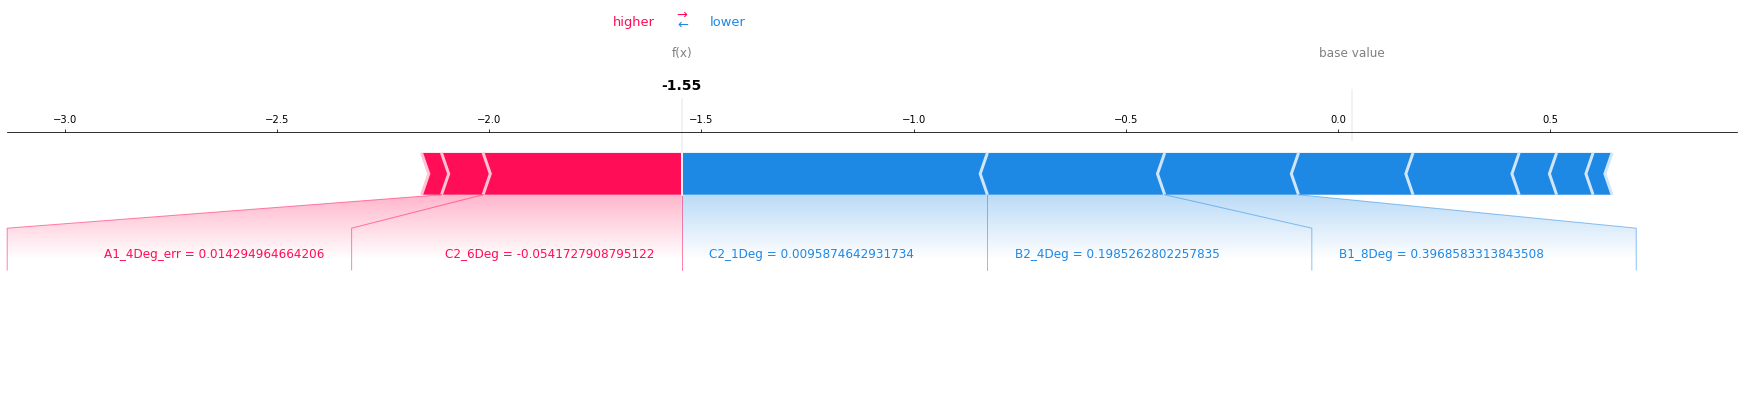

In [494]:
explainer = shap.TreeExplainer(classifier)
shap_values = explainer.shap_values(x_train)

# visualize the first prediction's explanation 
#shap.initjs()
import matplotlib
p =shap.force_plot(explainer.expected_value, shap_values[1,:], x_train.iloc[1,:],matplotlib = True, show = False)
fig = matplotlib.pyplot.gcf()
fig.set_size_inches(31,5)
plt.savefig('shap[1].png',dpi=600,bbox_inches='tight')
plt.show()
# 
# fig.set_size_inches(3.5, 7)
# plt.show()
#shap.save_html("index.htm", f)

In [180]:
shap.initjs()
def p(j):
    explainer = shap.TreeExplainer(xgb_model)
    xgb_binary_shap_values = explainer.shap_values(X_train)
    return(shap.force_plot(explainer.expected_value, xgb_binary_shap_values[j,:], X_train.iloc[j,:], link='logit'))
p(0)
#plt.savefig("new.png", format='png', dpi=600)

AttributeError: 'numpy.ndarray' object has no attribute 'iloc'

In [1]:
import matplotlib
matplotlib.__version__

'3.4.3'

[0]	validation_0-error:0.13043	validation_0-logloss:0.66678	validation_1-error:0.50000	validation_1-logloss:0.68942
[1]	validation_0-error:0.13043	validation_0-logloss:0.64268	validation_1-error:0.50000	validation_1-logloss:0.68701
[2]	validation_0-error:0.13043	validation_0-logloss:0.62061	validation_1-error:0.50000	validation_1-logloss:0.68577
[3]	validation_0-error:0.13043	validation_0-logloss:0.59444	validation_1-error:0.50000	validation_1-logloss:0.66231
[4]	validation_0-error:0.13043	validation_0-logloss:0.57527	validation_1-error:0.50000	validation_1-logloss:0.66252
[5]	validation_0-error:0.04348	validation_0-logloss:0.55219	validation_1-error:0.33333	validation_1-logloss:0.64174
[6]	validation_0-error:0.04348	validation_0-logloss:0.53531	validation_1-error:0.33333	validation_1-logloss:0.63895
[7]	validation_0-error:0.04348	validation_0-logloss:0.51494	validation_1-error:0.33333	validation_1-logloss:0.62055
[8]	validation_0-error:0.04348	validation_0-logloss:0.49615	validation_1

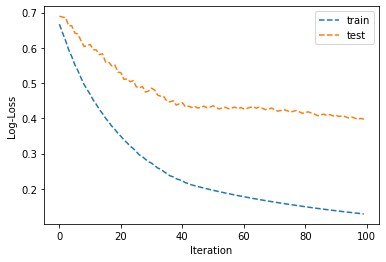

In [72]:
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.20, random_state=7)
# define the model
model = xgb.XGBClassifier(eta=0.066)
# define the datasets to evaluate each iteration
evalset = [(X_train, y_train), (X_test,y_test)]
# fit the model
model.fit(X_train, y_train, eval_metric=["error",'logloss'], eval_set=evalset)
# evaluate performance
yhat = model.predict(X_test)
score = accuracy_score(y_test, yhat)
print('Accuracy: %.3f' % score)
# retrieve performance metrics
results = model.evals_result()
# plot learning curves
plt.plot(results['validation_0']['logloss'], label='train',ls='--')
plt.plot(results['validation_1']['logloss'], label='test',ls='--')
plt.xlabel('Iteration')
plt.ylabel('Log-Loss')
# show the legend
plt.legend()
# show the plot

plt.savefig("loss_1.png", format='png', dpi=600)
plt.show()

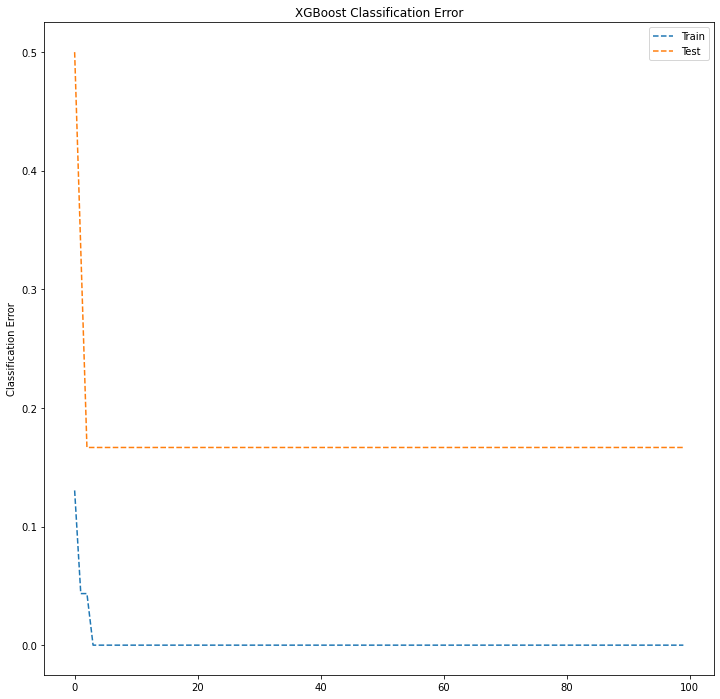

In [437]:
fig, ax = plt.subplots(figsize=(12,12))
ax.plot(results['validation_0']['error'], label='Train',ls='--')
ax.plot(results['validation_1']['error'], label='Test',ls='--')
ax.legend()

plt.ylabel('Classification Error')
plt.title('XGBoost Classification Error')
plt.show()

In [506]:
model = xgb.XGBClassifier(objective= 'binary:logistic')

[0]	validation_0-logloss:0.66273	validation_0-auc:0.86508	validation_0-error:0.17391	validation_1-logloss:0.68533	validation_1-auc:0.80000	validation_1-error:0.33333
[1]	validation_0-logloss:0.63782	validation_0-auc:0.95238	validation_0-error:0.13043	validation_1-logloss:0.67153	validation_1-auc:0.70000	validation_1-error:0.33333
[2]	validation_0-logloss:0.61741	validation_0-auc:1.00000	validation_0-error:0.04348	validation_1-logloss:0.66665	validation_1-auc:0.80000	validation_1-error:0.33333
[3]	validation_0-logloss:0.59615	validation_0-auc:1.00000	validation_0-error:0.04348	validation_1-logloss:0.65684	validation_1-auc:0.80000	validation_1-error:0.33333
[4]	validation_0-logloss:0.57831	validation_0-auc:0.97619	validation_0-error:0.17391	validation_1-logloss:0.65484	validation_1-auc:0.80000	validation_1-error:0.33333
[5]	validation_0-logloss:0.54635	validation_0-auc:1.00000	validation_0-error:0.00000	validation_1-logloss:0.62456	validation_1-auc:0.80000	validation_1-error:0.16667
[6]	

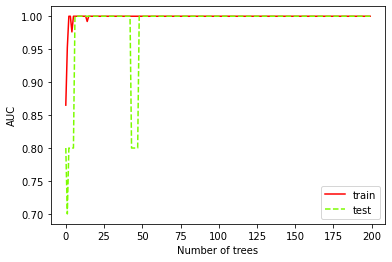

In [53]:
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.20, random_state=7)
# define the model
#best_model = xgb.XGBClassifier(objective= 'binary:logistic',eta=0.006,n_estimators=300)
# define the datasets to evaluate each iteration
evalset = [(X_train, y_train), (X_test,y_test)]
#model = xgb.XGBClassifier(eta=0.066)
# fit the model
best_model.fit(X_train, y_train, eval_metric=['logloss','auc','error'], eval_set=evalset)
# evaluate performance
yhat = best_model.predict(X_test)
score = accuracy_score(y_test, yhat)
print('Accuracy: %.3f' % score)
# retrieve performance metrics
results = best_model.evals_result()
# plot learning curves
plt.plot(results['validation_0']['auc'], label='train',color='r')
plt.plot(results['validation_1']['auc'], label='test',color='lawngreen',ls='--')
plt.xlabel('Number of trees')
plt.ylabel('AUC')
# show the legend
plt.legend()
# show the plot

#plt.savefig("auc.png", format='png', dpi=600)
plt.show()

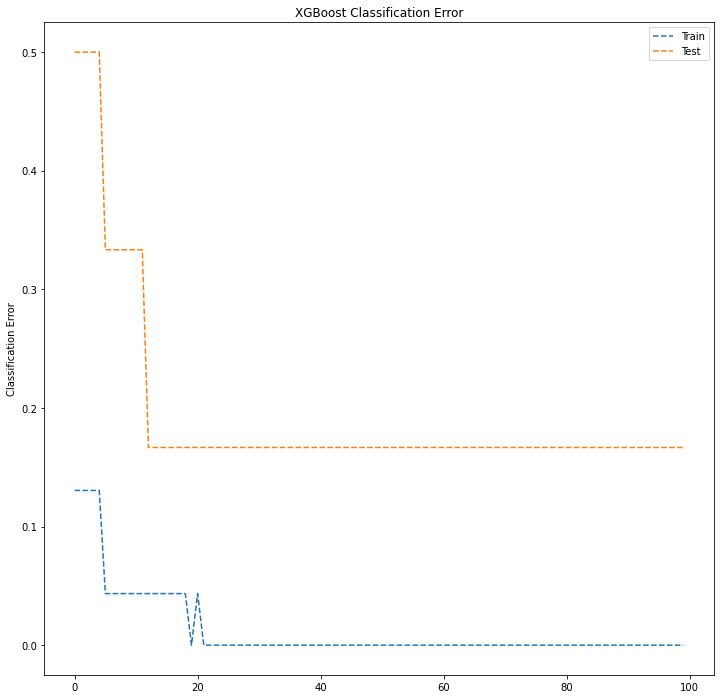

In [477]:
fig, ax = plt.subplots(figsize=(12,12))
ax.plot(results['validation_0']['error'], label='Train',ls='--')
ax.plot(results['validation_1']['error'], label='Test',ls='--')
ax.legend()

plt.ylabel('Classification Error')
plt.title('XGBoost Classification Error')
plt.show()

[0]	validation_0-logloss:0.67343	validation_1-logloss:0.69347
[1]	validation_0-logloss:0.65705	validation_1-logloss:0.69325
[2]	validation_0-logloss:0.64165	validation_1-logloss:0.69359
[3]	validation_0-logloss:0.62716	validation_1-logloss:0.69443
[4]	validation_0-logloss:0.61351	validation_1-logloss:0.69574
[5]	validation_0-logloss:0.60064	validation_1-logloss:0.69748
[6]	validation_0-logloss:0.58849	validation_1-logloss:0.69961
[7]	validation_0-logloss:0.57702	validation_1-logloss:0.70209
[8]	validation_0-logloss:0.56619	validation_1-logloss:0.70490
[9]	validation_0-logloss:0.55567	validation_1-logloss:0.70224
[10]	validation_0-logloss:0.54555	validation_1-logloss:0.69615
[11]	validation_0-logloss:0.53559	validation_1-logloss:0.69920
[12]	validation_0-logloss:0.52612	validation_1-logloss:0.69344
[13]	validation_0-logloss:0.51681	validation_1-logloss:0.69668
[14]	validation_0-logloss:0.50780	validation_1-logloss:0.69441
[15]	validation_0-logloss:0.49909	validation_1-logloss:0.69791
[1

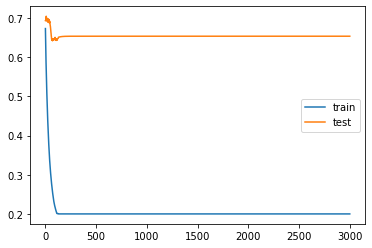

In [413]:
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.50, random_state=2)
# define the model
model = xgb.XGBClassifier(n_estimators=3000,eta=0.05)
# define the datasets to evaluate each iteration
evalset = [(X_train, y_train), (X_test,y_test)]
# fit the model
model.fit(X_train, y_train, eval_metric='logloss', eval_set=evalset)
# evaluate performance
yhat = model.predict(X_test)
score = accuracy_score(y_test, yhat)
print('Accuracy: %.3f' % score)
# retrieve performance metrics
results = model.evals_result()
# plot learning curves
plt.plot(results['validation_0']['logloss'], label='train')
plt.plot(results['validation_1']['logloss'], label='test')
# show the legend
plt.legend()
# show the plot
plt.show()